<a href="https://colab.research.google.com/github/kriptoks/kriptoks/blob/main/3gunluktahmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.7 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 112 kB 44.5 MB/s 
     |████████████████████████████████| 127 kB 50.8 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=7285ef9a9b473e0dad7ae16ffafb6f72e1192a75f6f8c02e4ad07c8d371194f5
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=99231ce1600d6910fec66940ec1977a6e8e623a0651a7e3a6d297d053a819ea3
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=571e1d3930e35962bc205a8717b84fb546c220d7a37a1e67a0843

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'BTC-USD'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:

# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

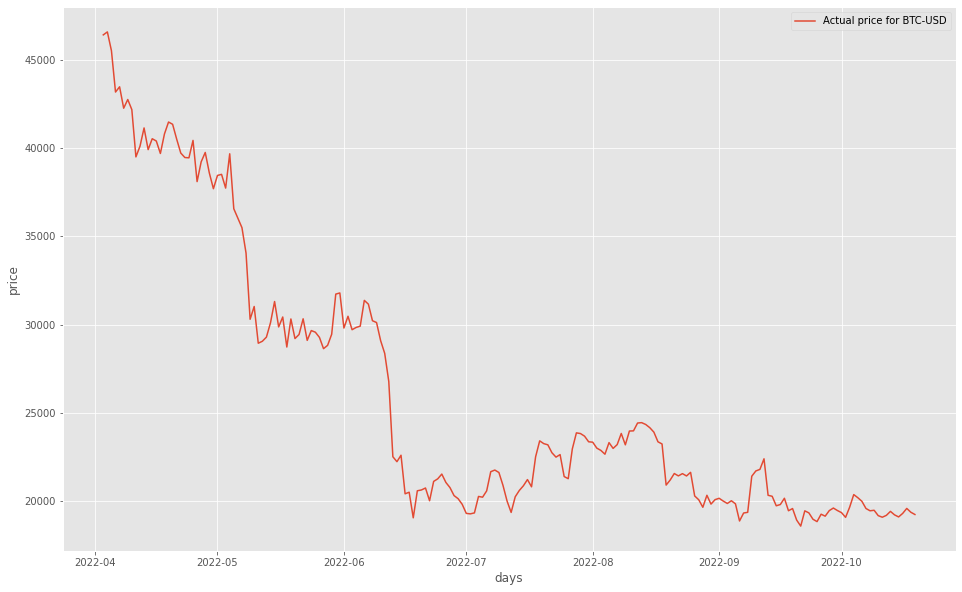

In [6]:

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [7]:

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [8]:

def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [9]:

def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [10]:

# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
138/138 [==============================] - 9s 23ms/step - loss: 0.0102
Epoch 2/80
138/138 [==============================] - 3s 21ms/step - loss: 0.0031
Epoch 3/80
138/138 [==============================] - 3s 22ms/step - loss: 0.0030
Epoch 4/80
138/138 [==============================] - 3s 23ms/step - loss: 0.0025
Epoch 5/80
138/138 [==============================] - 3s 19ms/step - loss: 0.0025
Epoch 6/80
138/138 [==============================] - 3s 24ms/step - loss: 0.0023
Epoch 7/80
138/138 [==============================] - 3s 23ms/step - loss: 0.0019
Epoch 8/80
138/138 [==============================] - 3s 20ms/step - loss: 0.0020
Epoch 9/80
138/138 [==============================] - 2s 13ms/step - loss: 0.0023
Epoch 10/80
138/138 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 11/80
138/138 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 12/80
138/138 [==============================] - 2s 12ms/step - loss: 0.0017
Epoch 13/80
1

In [11]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = [str(d)+'tl' for d in predictions]
    predictions_str = ','.join(predictions_list)
    message = f'{STOCK} önümüzdeki 3 gün için tahmin ({predictions_str})'
    print(message)

BTC-USD önümüzdeki 3 gün için tahmin (20184.3tl,19878.38tl,19771.55tl)
